In [1]:
from app1 import *
import matplotlib.pyplot as plt

%matplotlib nbagg
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

capture = WebcamCapture()
model = ModelPipeline()

In [9]:
height, width, _ = capture.read().shape

<IPython.core.display.Javascript object>


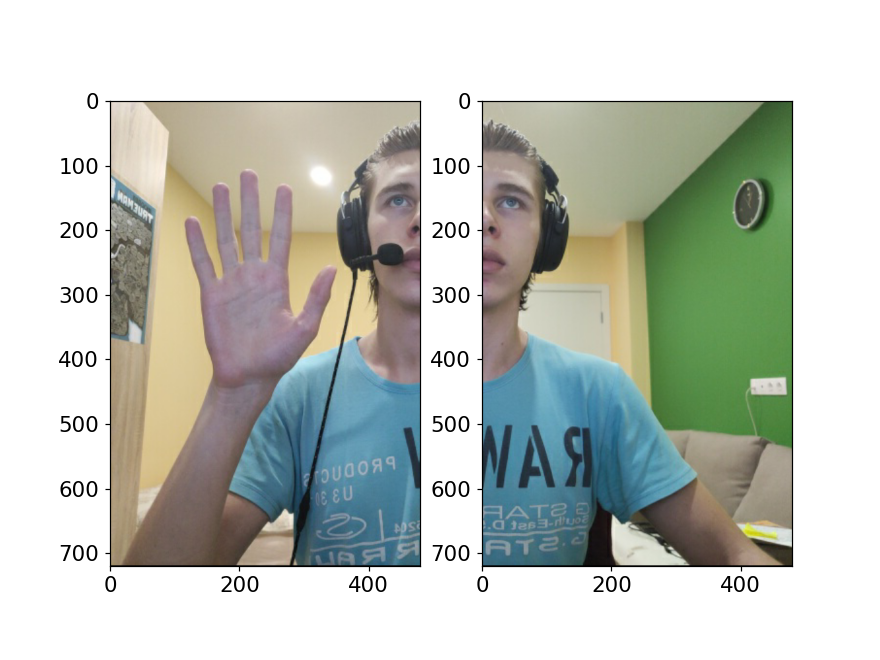

<IPython.core.display.Javascript object>


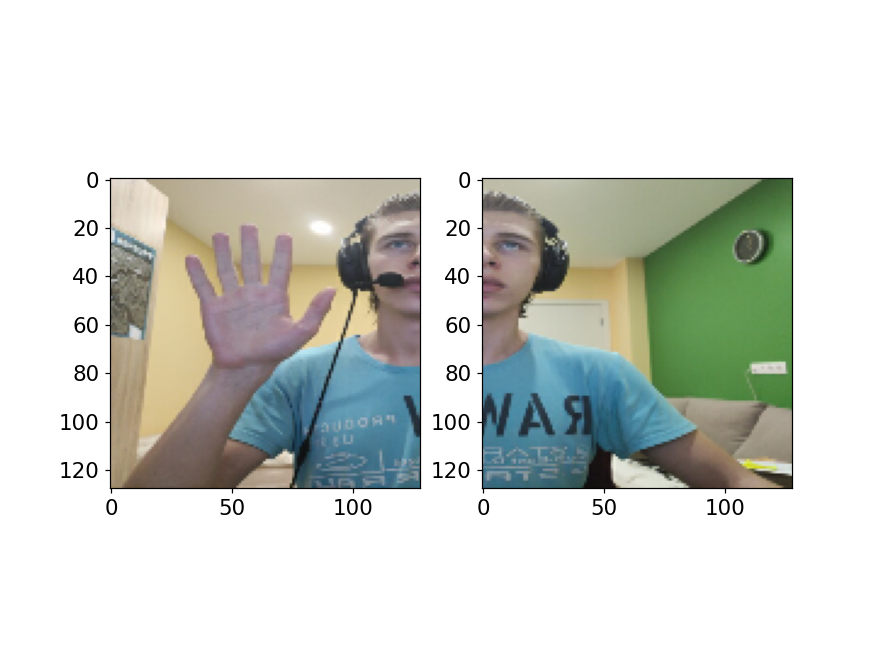

In [13]:
# time.sleep(2)

frame_large = capture.read_rgb()
frame_large_l = frame_large[:, :width // 2]
frame_large_r = frame_large[:, width // 2:]

# size = min(int(width / 2), height)
# margin_h = int((width - 2 * size) / 2)
# margin_v = int((height - size) / 2)
# 
# frame_large_l = frame_large[margin_v:size + margin_v, margin_h:size + margin_h]
# frame_large_r = frame_large[margin_v:size + margin_v:, width - margin_h - size:width - margin_h]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frame_large_l)
ax2.imshow(frame_large_r)
fig.show()

frame_l = imresize(frame_large_l, (128, 128))
frame_r = imresize(frame_large_r, (128, 128))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frame_l)
ax2.imshow(frame_r)
fig.show()

<IPython.core.display.Javascript object>


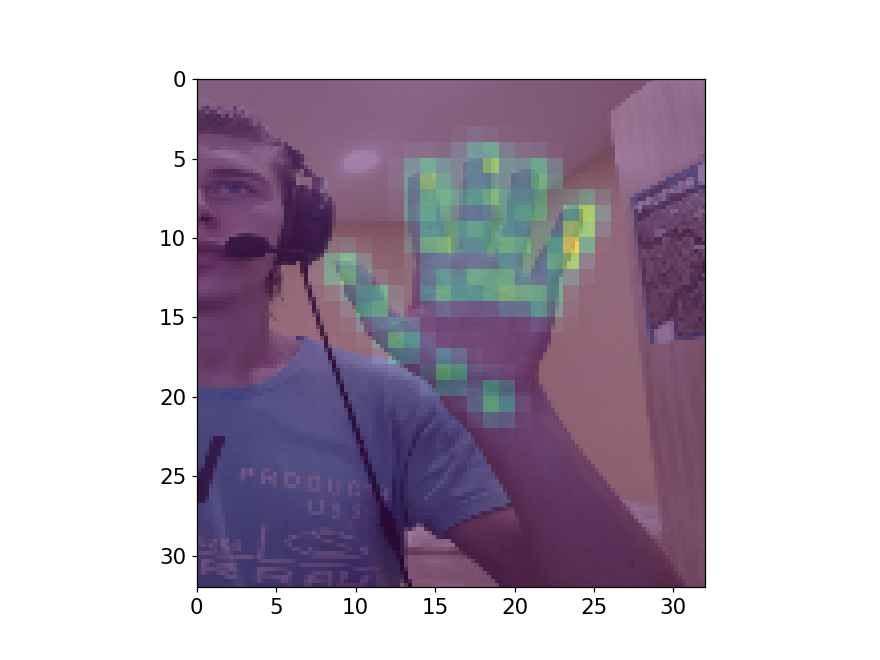

<IPython.core.display.Javascript object>


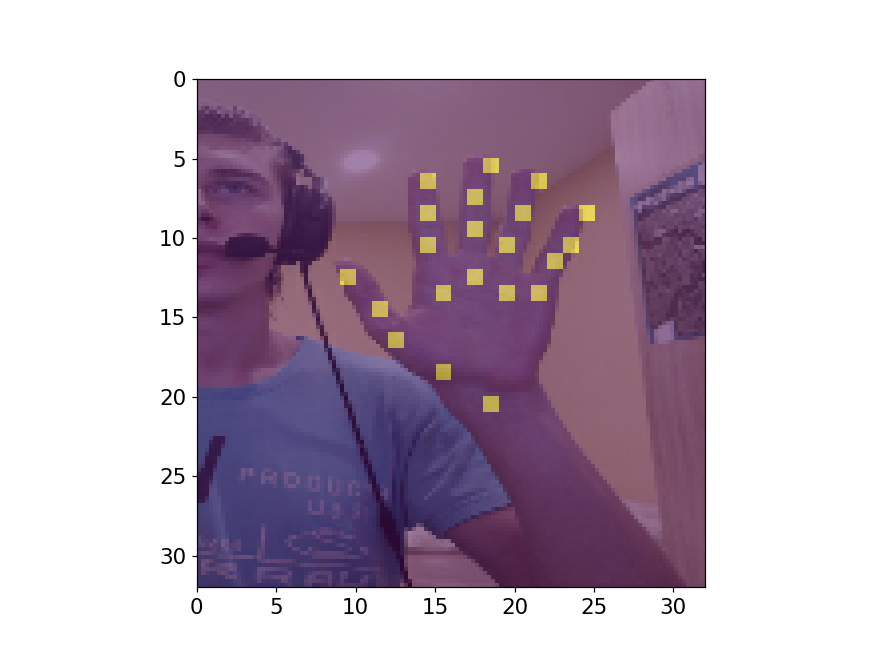

<IPython.core.display.Javascript object>


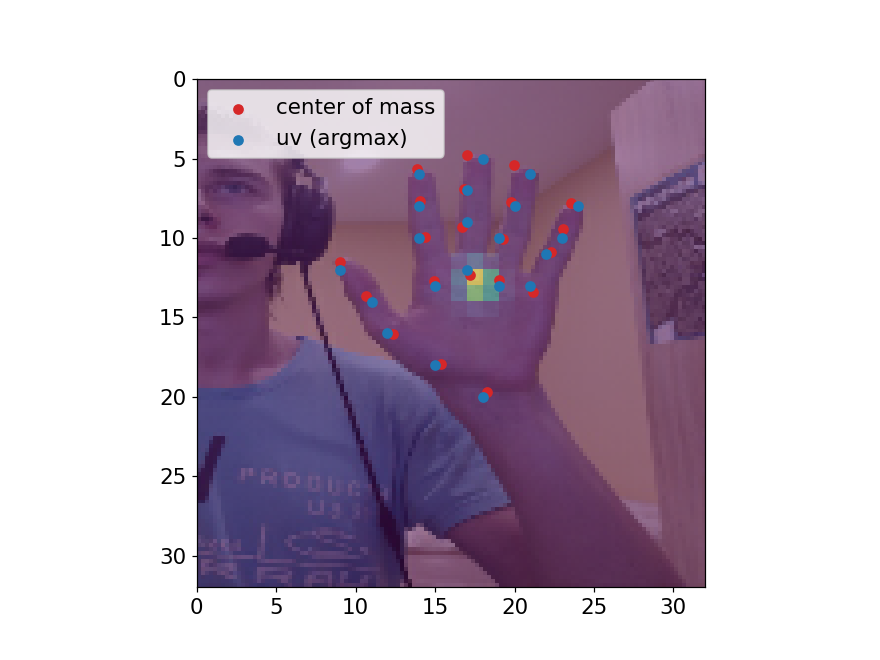

<IPython.core.display.Javascript object>


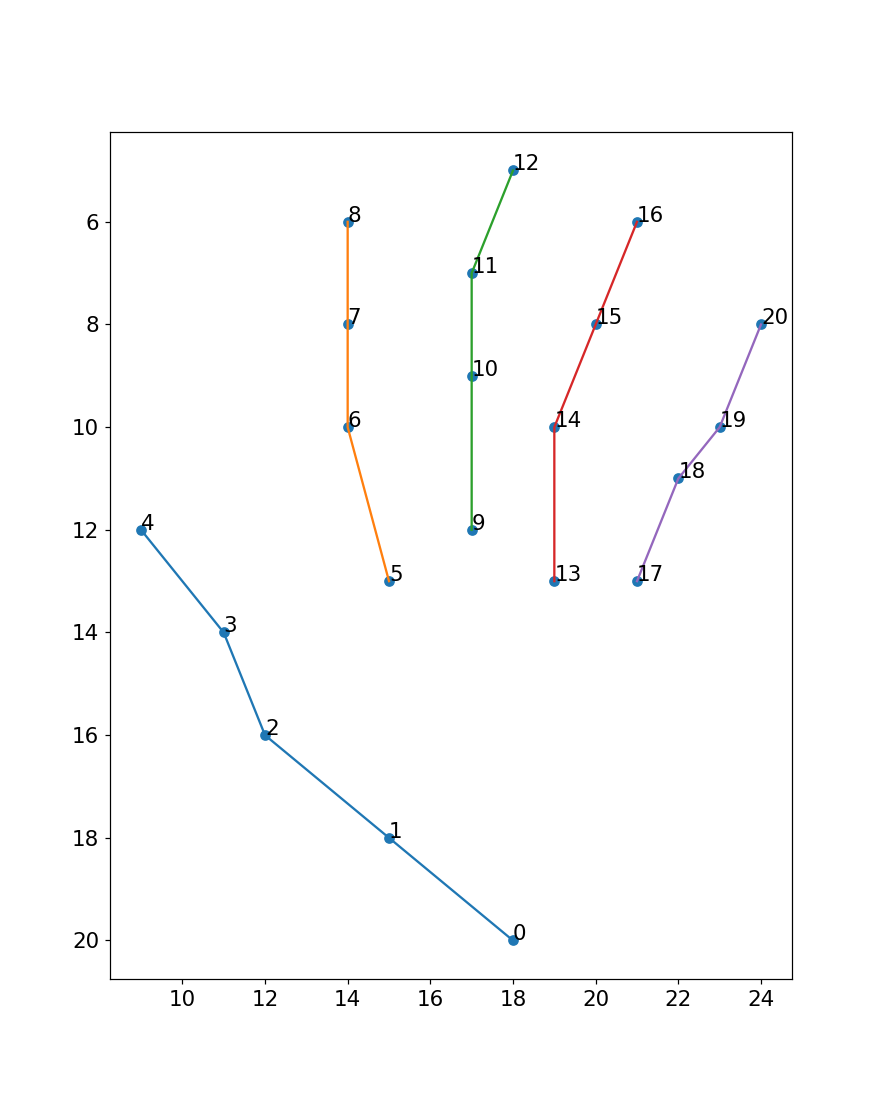

<IPython.core.display.Javascript object>


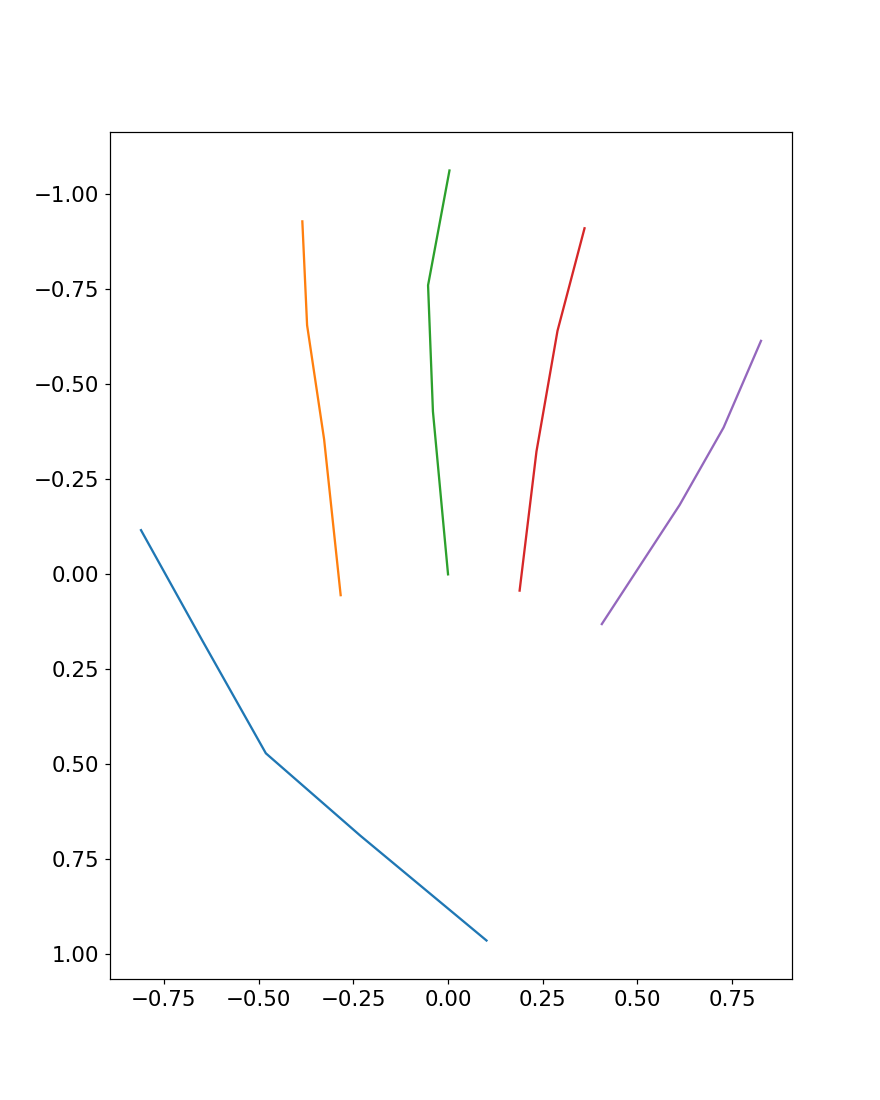

<IPython.core.display.Javascript object>


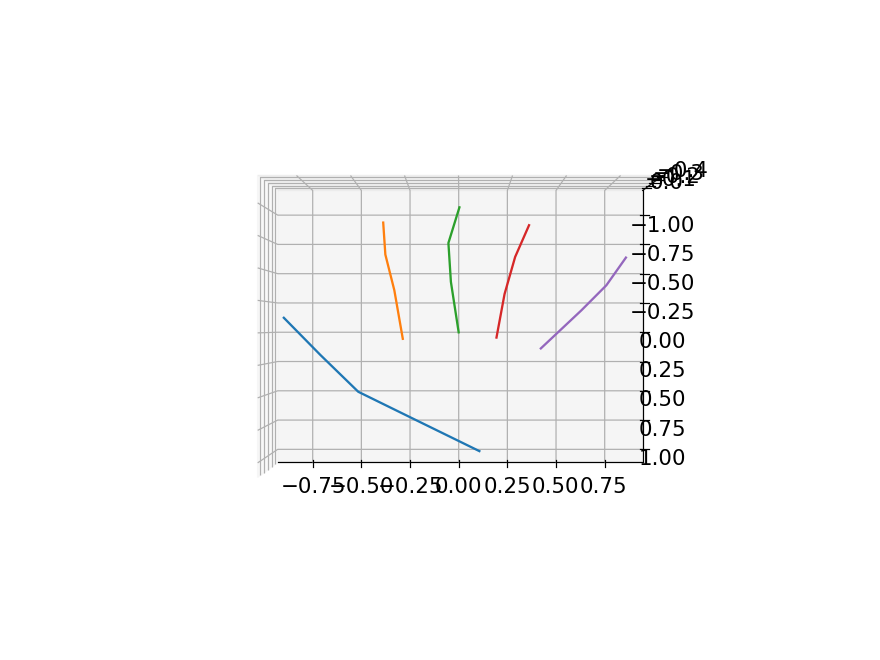

In [21]:
from scipy import ndimage

extent32 = extent=[0, 32, 32, 0]

ivl, _ = model.process(np.flip(frame_l, axis=1))
ivr, _ = model.process(frame_r)


plt.figure('Joined heatmaps')
plt.imshow(np.flip(frame_l, axis=1), extent=extent32)
plt.imshow(np.sum(ivl.hmap[0], axis=2), alpha=.5, extent=extent32)
plt.show()


plt.figure('UV (argmax)')
plt.imshow(np.flip(frame_l, axis=1), extent=extent32)
grid = np.zeros((32, 32))
grid[ivl.uv[:, 0], ivl.uv[:, 1]] = 1
plt.imshow(grid, alpha=.5, extent=extent32)
plt.show()
plt.show()


plt.figure()
plt.imshow(np.flip(frame_l, axis=1), extent=extent32)
plt.imshow(ivl.hmap[0][..., 9], alpha=.5, extent=extent32)

# center_of_mass returns tuple
xy = np.array([ndimage.measurements.center_of_mass(hm)[::-1] for hm in ivl.hmap[0].swapaxes(0, 2)])
plt.scatter(xy[:, 1], xy[:, 0], c='tab:red', label='center of mass')
plt.scatter(ivl.uv[:, 1], ivl.uv[:, 0], label='uv (argmax)')
plt.legend()
plt.show()


plt.figure('Enumerated UV', figsize=(8, 10))
plt.gca().invert_yaxis()

plt.scatter(ivl.uv[:, 1], ivl.uv[:, 0])
plt.plot(ivl.uv[:5, 1], ivl.uv[:5, 0])
plt.plot(ivl.uv[5:9, 1], ivl.uv[5:9, 0])
plt.plot(ivl.uv[9:13, 1], ivl.uv[9:13, 0])
plt.plot(ivl.uv[13:17, 1], ivl.uv[13:17, 0])
plt.plot(ivl.uv[17:, 1], ivl.uv[17:, 0])

for i in range(21):
    plt.annotate(str(i), (ivl.uv[i, 1], ivl.uv[i, 0]))


plt.figure('XYZ, XY projection', figsize=(8, 10))
plt.gca().invert_yaxis()
plt.plot(ivl.xyz[:5, 0], ivl.xyz[:5, 1])
plt.plot(ivl.xyz[5:9, 0], ivl.xyz[5:9, 1])
plt.plot(ivl.xyz[9:13, 0], ivl.xyz[9:13, 1])
plt.plot(ivl.xyz[13:17, 0], ivl.xyz[13:17, 1])
plt.plot(ivl.xyz[17:, 0], ivl.xyz[17:, 1])


ax3d = plt.figure('XYZ, 3D').add_subplot(111, projection='3d')
ax3d.view_init(-90, -90)
ax3d.plot(ivl.xyz[:5, 0], ivl.xyz[:5, 1], ivl.xyz[:5, 2])
ax3d.plot(ivl.xyz[5:9, 0], ivl.xyz[5:9, 1], ivl.xyz[5:9, 2])
ax3d.plot(ivl.xyz[9:13, 0], ivl.xyz[9:13, 1], ivl.xyz[9:13, 2])
ax3d.plot(ivl.xyz[13:17, 0], ivl.xyz[13:17, 1], ivl.xyz[13:17, 2])
ax3d.plot(ivl.xyz[17:, 0], ivl.xyz[17:, 1], ivl.xyz[17:, 2])
plt.show()

In [22]:
import numpy as np


def unit_vector(vector):
    return np.divide(vector, np.linalg.norm(vector))


def closest_angle(v1, v2):
    return np.arccos(np.clip(np.dot(unit_vector(v1), unit_vector(v2)), -1.0, 1.0))


def clockwise_angle(v1, v2):
    return (np.arctan2(*v1[::-1]) - np.arctan2(*v2[::-1])) % (2 * np.pi)


assert np.isclose(closest_angle((0, 1), (0, 1)), 0)
assert np.isclose(clockwise_angle((0, 1), (0, 1)), 0)

assert np.isclose(closest_angle((0, 1), (0, -1)), np.pi)
assert np.isclose(clockwise_angle((0, 1), (0, -1)), np.pi)

assert np.isclose(closest_angle((0, 1), (1, 0)), (1 / 4) * (2 * np.pi))
assert np.isclose(closest_angle((0, -1), (1, 0)), (1 / 4) * (2 * np.pi))

assert np.isclose(clockwise_angle((0, 1), (1, 0)), (1 / 4) * (2 * np.pi))
assert np.isclose(clockwise_angle((0, -1), (1, 0)), (3 / 4) * (2 * np.pi))

vectors = [ivl.xyz[i * 4 + 1, :2] - ivl.xyz[0, :2] for i in range(5)]
print(sum(closest_angle(vectors[i], vectors[i + 1]) for i in range(4)))

1.2291357349523944


<IPython.core.display.Javascript object>


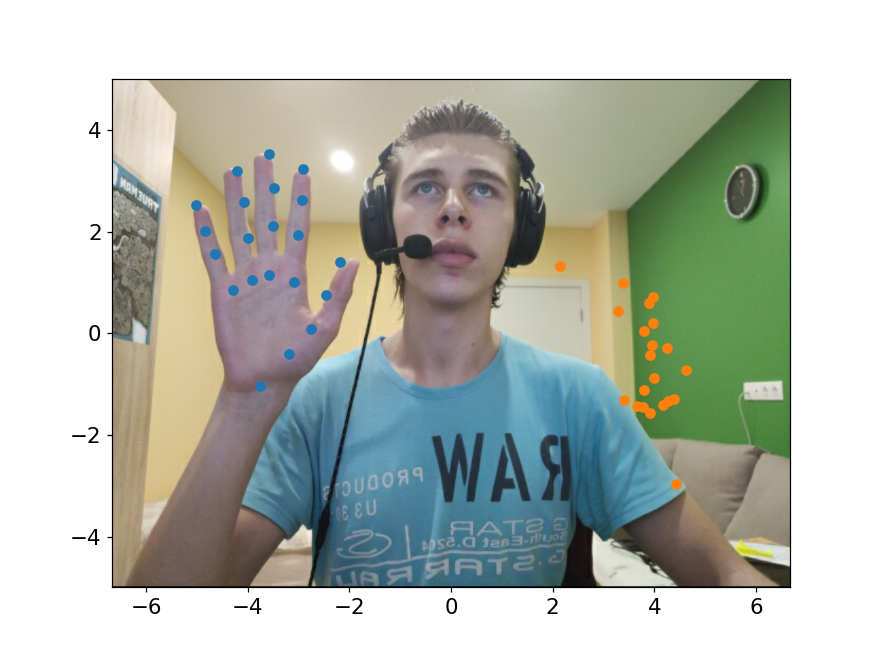

In [31]:
frustumHeight = 10
frustumWidth = 13.33333

indexes_y = np.arange(5, 21).reshape((4, 4))
# indexes_y = np.arange(1, 21).reshape((5, 4))
indexes_x = indexes_y.T


def calc_hand_data(iv):
    origin = to_vec(calc_origin(iv.hmap[0][..., 9]))
#     origin = to_vec([iv.uv[9][1] / 32, 1 - (iv.uv[9][0]) / 32])
    
#     UV instead of XY
#     joints = list([to_vec([*(uv[::-1]/32), xyz[2]]) for xyz, uv in zip(iv.xyz, iv.uv)])
#     joints = list([to_vec([*(uv[::-1]/32), xyz[2]]) for xyz, uv in zip(iv.xyz, xy)])
    
    joints = list([to_vec(xyz) for xyz in iv.xyz.tolist()])  # tolist, because 0mq can't work with np.float

    def calc_dists(indexes):
        return np.array([
            np.linalg.norm(iv.xyz[i[1:], :2] - iv.xyz[i[:-1], :2]) * 32 /
            np.linalg.norm(iv.uv[i[1:]] - iv.uv[i[:-1]])
            for i in indexes
        ])

    dists_x = filter_nan_inf(calc_dists(indexes_x))
    dists_y = filter_nan_inf(calc_dists(indexes_y))

    if dists_x.size == 0 or dists_y.size == 0:
        return None

    dist_x = np.mean(dists_x)
    dist_y = np.mean(dists_y)
    
#     palm_size = sum(np.linalg.norm(iv.xyz[0] - iv.xyz[i]) for i in [1, 5, 9, 13, 17])
    
    u09 = unit_vector(iv.xyz[9, :2] - iv.xyz[0, :2])
#     horiz = abs(2 * np.arcsin(u09[0]) / np.pi)
    vert = abs(2 * np.arcsin(u09[1]) / np.pi)
    
    return origin, joints, dist_x, dist_y, vert


data_originL, data_jointsL, data_distXL, data_distYL, data_vertL = calc_hand_data(ivl)
data_originR, data_jointsR, data_distXR, data_distYR, data_vertR = calc_hand_data(ivr)

scaleXL = data_vertL * data_distXL + (1 - data_vertL) * data_distYL
scaleYL = data_vertL * data_distYL + (1 - data_vertL) * data_distXL

scaleXR = data_vertR * data_distXR + (1 - data_vertR) * data_distYR
scaleYR = data_vertR * data_distYR + (1 - data_vertR) * data_distXR

# UV instead of XY
# data_distXL = 1
# data_distYL = 1
# data_distXR = 1
# data_distYR = 1
# data_originL = {'x': 0, 'y': 1}
# data_originR = {'x': 0, 'y': 1}

plt.figure()
plt.imshow(frame_large, extent=[-frustumWidth / 2, frustumWidth / 2, -frustumHeight / 2, frustumHeight / 2])
plt.scatter([(-data_jointsL[i]['x'] / scaleXL - data_originL['x']) * (frustumWidth / 2) for i in range(21)], 
            [(-data_jointsL[i]['y'] / scaleYL + (data_originL['y'] - 0.5)) * frustumHeight for i in range(21)])
plt.scatter([(+data_jointsR[i]['x'] / scaleXR + data_originR['x']) * (frustumWidth / 2) for i in range(21)], 
            [(-data_jointsR[i]['y'] / scaleYR + (data_originR['y'] - 0.5)) * frustumHeight for i in range(21)])
plt.show()